In [1]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

from utils import *

from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map


from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

from sklearn.ensemble import RandomForestClassifier

from sklearn.base import clone as sklearn_clone

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load data

In [2]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment']
X_train = df.copy().loc[:, df.columns != 'assestment']

In [3]:
y_train.value_counts()

0    3439
1    3103
Name: assestment, dtype: int64

## Analysis words frequencies

In [4]:
tasks = X_train['text_clean'].values.tolist()
result = progress_map(tokenize, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train['words'] = result

X_train = X_train[X_train['words'].apply(len)>0]
y_train = y_train[y_train.index.isin(X_train.index)]

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

In [5]:
df_one = X_train.copy()

# df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

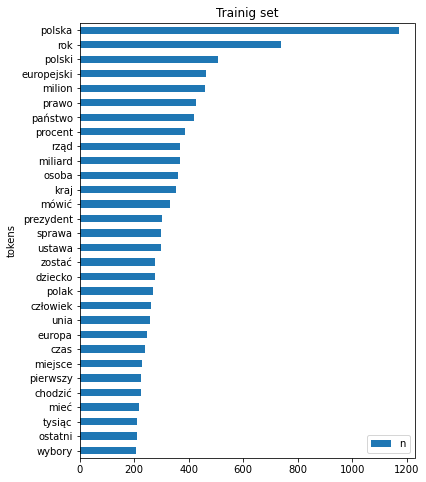

In [6]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

### Remove extra stopwords

In [7]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'polski', 'europejski', 'milion',
                        'prawo', 'państwo', 
                        'procent', 'rząd', 'miliard', 'osoba', 'kraj', 'mowić'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [8]:
def filter_stop_words(words, stop_words = extra_stop_words):
    out = [x for x in words if x not in stop_words]
    return out

tasks = X_train['words'].values.tolist()
result = progress_map(filter_stop_words, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train['words_clean'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

### Add features

In [9]:
n_grams = 5
min_pos = 5 

In [10]:
X_pos = X_train[['TEXT_POS']].copy()

words =  sum(X_pos['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = X_pos['TEXT_POS'].str.count(' '.join(n)) / X_pos['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
X_pos = pd.concat( [X_pos] + list( col.values() ), axis=1 ).drop('TEXT_POS', axis=1)

100%|█████████████████████████████████████| 13668/13668 [11:06<00:00, 20.49it/s]


In [12]:
# X_pos.join(y_train).to_csv('../datasets/ready2use/pos_pl_dataset.csv', sep=';', index=False, encoding='utf8')

In [11]:
X_ngram = X_train[['words_clean']].copy()

X_ngram['words_clean'] = X_ngram['words_clean'].apply(lambda l: " ".join(l))

words =  sum(X_ngram['words_clean'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()

col = {}
    
for n in tqdm(n_iterator):
    x = X_ngram['words_clean'].str.count(' '.join(n)) / X_ngram['words_clean'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
X_ngram = pd.concat( [X_ngram] + list( col.values() ), axis=1 ).drop('words_clean', axis=1)

100%|███████████████████████████████████████| 2792/2792 [00:58<00:00, 47.56it/s]


In [12]:
y_train_u = y_train.sort_index()
    
X_train_u = X_train.sort_index()
X_pos_u = X_pos.sort_index()
X_ngram_u = X_ngram.sort_index()

## CV creation
### LDA

In [13]:
ideal_topic_num = 10

In [14]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_u['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

X_train_u['topic'] = topics

100%|█████████████████████████████████████| 6541/6541 [00:01<00:00, 6013.00it/s]


In [15]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.022*"sprawa" + 0.014*"sprawiedliwość" + 0.008*"lekarz" + 0.008*"mówić" + 0.008*"prezes"
1 0.018*"trybunał" + 0.015*"ustawa" + 0.013*"konstytucja" + 0.013*"wybory" + 0.013*"konstytucyjny"
2 0.014*"budżet" + 0.014*"unia" + 0.010*"miejsce" + 0.008*"mieszkanie" + 0.008*"warszawa"
3 0.015*"złoty" + 0.010*"dziecko" + 0.009*"pkb" + 0.008*"mówić" + 0.008*"tysiąc"
4 0.020*"europa" + 0.018*"ostatni" + 0.015*"wzrost" + 0.011*"poziom" + 0.010*"ciąg"
5 0.013*"człowiek" + 0.010*"praca" + 0.009*"szkoła" + 0.008*"polak" + 0.007*"dziecko"
6 0.017*"projekt" + 0.013*"ustawa" + 0.012*"rada" + 0.009*"polityczny" + 0.008*"podatek"
7 0.015*"program" + 0.015*"dziecko" + 0.011*"człowiek" + 0.010*"rodzina" + 0.008*"tysiąc"
8 0.012*"prezydent" + 0.012*"kaczyński" + 0.007*"sędzia" + 0.007*"zostać" + 0.007*"chcieć"
9 0.012*"sędzia" + 0.011*"zostać" + 0.010*"komisja" + 0.010*"sąd" + 0.010*"polak"


In [16]:
y_train_u_test = pd.DataFrame(y_train_u.copy())
y_train_u_test['topic'] = X_train_u['topic']
y_train_u_test['n'] = 1
y_train_u_test.groupby(['topic', 'assestment']).sum().reset_index().pivot('topic','assestment','n')

assestment,0,1
topic,,
0,340,260
1,326,297
2,347,443
3,325,327
4,363,417
5,380,310
6,318,291
7,340,268
8,337,240


### Kfold

In [17]:
cv_fold = []
cv_fold_i = []

for i in X_train_u['topic'].unique().reshape(10,-1):
    train_cv = X_train_u.index[ ~np.isin(X_train_u["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(X_train_u["topic"], i) ].values
    
    train_cv_i = X_train_u.reset_index().index[ ~np.isin(X_train_u["topic"], i) ].values
    test_cv_i = X_train_u.reset_index().index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [36]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train_u)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(X_train_u):
    train_cv = X_train_u.iloc[ train_index, : ].index.values
    test_cv = X_train_u.iloc[ test_index, : ].index.values

    train_cv_i= X_train_u.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = X_train_u.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Run experiments

In [37]:
def run_experiment(X, y, cv, clf_org, r_min=0.05):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : [],
        'n_features': []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
    #     clf = RandomForestClassifier(random_state=111)

        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]

        # keep only columns with corr > 0.05
        col_keep = []
        for c in X_train_t.columns:
            min_v =X_train_t[c].values.min()
            max_v = X_train_t[c].values.max()

            if min_v < max_v:
                r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                if ~np.isnan(r) and r > r_min:
                    col_keep.append(c)
        
        if len(col_keep) == 0:
            print('No values returned')
        
        X_train_t = X_train_t[col_keep]


        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]

        X_test_t = X_test_t[col_keep]

        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)

        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        results['n_features'].append( len(col_keep) ) 

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
        "Precision": np.array(results['test_precision']).mean(),
        "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        "N features": np.array(results['n_features'])
        }

#     print(c_matrix)

    return metrics

In [38]:
X_features = X_train_u[['sentiment_all', 'sentiment_avg', 'uniq_words',
       'uniq_lemm', 'err', 'net', 'words_start_upper', 'words_full_upper',
       'exclamation_marks', 'question_marks', 'upper_letters', 'chars']]

## Topics Kfold

In [39]:
X_f_pos = X_features.reset_index().join(X_pos_u.reset_index(drop=True), how="left").set_index('index')

In [40]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    for clf_used, clf_name in zip(
        [clf_lr_1],['lr C1']
    ):
        out = run_experiment(X_used, y_train_u, cv_fold, clf_used, 0.05)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
            f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',        
        )

ngrams   lr C1 Accuracy 0.543+-0.043 F1 Score 0.114+-0.076
features lr C1 Accuracy 0.534+-0.038 F1 Score 0.355+-0.055
pos      lr C1 Accuracy 0.624+-0.030 F1 Score 0.503+-0.067
f + pos  lr C1 Accuracy 0.625+-0.028 F1 Score 0.525+-0.062


## Random Kfold

In [41]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
        
for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    for clf_used, clf_name in zip(
        [clf_lr_1],['lr C1']
    ):
        out = run_experiment(X_used, y_train_u, cv_Kfold, clf_used, 0.01)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
            f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
        )

ngrams   lr C1 Accuracy 0.597+-0.018 F1 Score 0.461+-0.029
features lr C1 Accuracy 0.535+-0.015 F1 Score 0.377+-0.019
pos      lr C1 Accuracy 0.626+-0.012 F1 Score 0.539+-0.018
f + pos  lr C1 Accuracy 0.626+-0.014 F1 Score 0.555+-0.015


## Use all features 

In [42]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

scoring = ['accuracy', 'precision', 'recall', 'f1']

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    
    col_keep = []
    for c in X_used.columns:
        min_v =X_used[c].values.min()
        max_v = X_used[c].values.max()

        if min_v < max_v:
            r = scipy.stats.pearsonr(X_used[c].values, y_train_u)[0]
            if ~np.isnan(r) and np.abs(r) > 0.05:
                col_keep.append(c)
                    
    results = cross_validate(estimator=clf_lr_1,
                           X=X_used[col_keep],
                           y=y_train_u,
                           cv=cv_fold_i, #10,
                           scoring=scoring,
                           return_train_score=True)
    print(
        x_name, 
        'lr C1',
        f'Accuracy {results["test_accuracy"].mean():.3f}+-{results["test_accuracy"].std():.3f}',
        f'F1 Score {results["test_f1"].mean():.3f}+-{results["test_f1"].std():.3f}',
    )

ngrams   lr C1 Accuracy 0.557+-0.039 F1 Score 0.322+-0.055
features lr C1 Accuracy 0.564+-0.027 F1 Score 0.462+-0.040
pos      lr C1 Accuracy 0.629+-0.029 F1 Score 0.536+-0.056
f + pos  lr C1 Accuracy 0.634+-0.025 F1 Score 0.556+-0.056


In [43]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

scoring = ['accuracy', 'precision', 'recall', 'f1']

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    
    col_keep = []
    for c in X_used.columns:
        min_v =X_used[c].values.min()
        max_v = X_used[c].values.max()

        if min_v < max_v:
            r = scipy.stats.pearsonr(X_used[c].values, y_train_u)[0]
            if ~np.isnan(r) and np.abs(r) > 0.05:
                col_keep.append(c)
                    
    results = cross_validate(estimator=clf_lr_1,
                           X=X_used[col_keep],
                           y=y_train_u,
                           cv=10, #10,
                           scoring=scoring,
                           return_train_score=True)
    print(
        x_name, 
        'lr C1',
        f'Accuracy {results["test_accuracy"].mean():.3f}+-{results["test_accuracy"].std():.3f}',
        f'F1 Score {results["test_f1"].mean():.3f}+-{results["test_f1"].std():.3f}',
    )

ngrams   lr C1 Accuracy 0.553+-0.033 F1 Score 0.322+-0.045
features lr C1 Accuracy 0.551+-0.048 F1 Score 0.458+-0.050
pos      lr C1 Accuracy 0.625+-0.073 F1 Score 0.540+-0.093
f + pos  lr C1 Accuracy 0.621+-0.066 F1 Score 0.548+-0.091
